In [100]:
# Importing the libraries
# !pip install easyocr -- Used for text detection. Reference: https://pypi.org/project/easyocr/1.6.2/
# Also yoloV3 used for object detection
# yolov3 reference: https://towardsdatascience.com/object-detection-and-tracking-in-pytorch-b3cf1a696a98, 
#                   https://github.com/cfotache/pytorch_objectdetecttrack/blob/master/PyTorch_Object_Detection.ipynb

import cv2 
import numpy as np
import matplotlib.pyplot as plt
import os
import os, sys, time, datetime, random
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.autograd import Variable
from models import *
import torchvision
from utils import *
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import easyocr

In [101]:
# Check if GPU is available. If yes, use GPU else use CPU 

def_device = "cuda" if torch.cuda.is_available() else "cpu"

In [102]:
# Get the image paths

image_paths = [os.path.join('./assignment/AI Applied Researcher Task', x) for x in os.listdir('./assignment/AI Applied Researcher Task') if x.endswith('.png')]

# APPROACH 1: Using object detection and rectanglular bounding boxes
## (P.S. Scroll to the bottom for the better approach)

In [103]:
# Load YoloV3
# Reference: https://towardsdatascience.com/object-detection-and-tracking-in-pytorch-b3cf1a696a98
# The following code is taken from the above reference
# I cloned the github repo and downloaded the weights and config files from the repo

config_path='pytorch_objectdetecttrack-master/config/yolov3.cfg'
weights_path='pytorch_objectdetecttrack-master/config/yolov3.weights'
class_path='pytorch_objectdetecttrack-master/config/coco.names'
img_size=416
conf_thres=0.8
nms_thres=0.4

# Load model and weights
model = Darknet(config_path, img_size=img_size)
model.load_weights(weights_path)
model.to(def_device)
model.eval()
classes = utils.load_classes(class_path)
Tensor = torch.cuda.FloatTensor

/home/shubham/.local/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [104]:
# Check a sample image

sample_image = cv2.imread(image_paths[0])
sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)

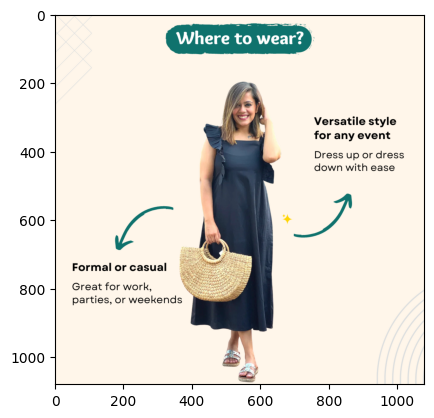

In [105]:
# Visualize the image

plt.imshow(sample_image)

In [106]:
# Function to detect objects in the image
# The following code is takenfrom the given reference

def detect_image(img):
    # scale and pad image
    ratio = min(img_size/img.shape[0], img_size/img.shape[1])
    imw = round(img.shape[0] * ratio)
    imh = round(img.shape[1] * ratio)
    img_transforms = transforms.Compose([ transforms.ToTensor(),transforms.Resize((imh, imw)),
         transforms.Pad((max(int((imh-imw)/2),0), max(int((imw-imh)/2),0), max(int((imh-imw)/2),0), max(int((imw-imh)/2),0)))])
    # convert image to Tensor
    image_tensor = img_transforms(img).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input_img = image_tensor.to(def_device)
    # run inference on the model and get detections
    with torch.no_grad():
        detections = model(input_img)
        detections = utils.non_max_suppression(detections, 80, conf_thres, nms_thres)
    return detections[0]

(1080, 1080, 3)


/home/shubham/.local/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


<Figure size 640x480 with 0 Axes>

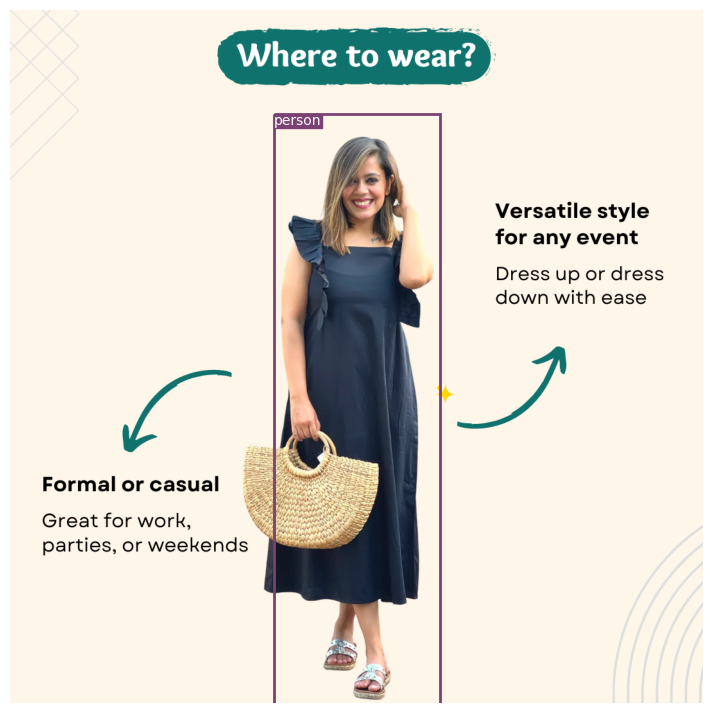

In [107]:
# Run the function on the sample image and visualize the output
# The following code is takenfrom the given reference

img_path = image_paths[0]
prev_time = time.time()
img = Image.open(img_path)
detections = detect_image(sample_image)

# Get bounding-box colors
cmap = plt.get_cmap('tab20b')
colors = [cmap(i) for i in np.linspace(0, 1, 20)]

img = np.array(sample_image)
plt.figure()
fig, ax = plt.subplots(1, figsize=(12,9))
ax.imshow(img)
print(img.shape)
pad_x = max(img.shape[0] - img.shape[1], 0) * (img_size / max(img.shape))
pad_y = max(img.shape[1] - img.shape[0], 0) * (img_size / max(img.shape))
unpad_h = img_size - pad_y
unpad_w = img_size - pad_x

if detections is not None:
    unique_labels = detections[:, -1].cpu().unique()
    n_cls_preds = len(unique_labels)
    bbox_colors = random.sample(colors, n_cls_preds)
    # browse detections and draw bounding boxes
    for x1, y1, x2, y2, conf, cls_conf, cls_pred in detections.cpu().numpy():
        box_h = ((y2 - y1) / unpad_h) * img.shape[0]
        box_w = ((x2 - x1) / unpad_w) * img.shape[1]
        y1 = ((y1 - pad_y // 2) / unpad_h) * img.shape[0]
        x1 = ((x1 - pad_x // 2) / unpad_w) * img.shape[1]
        color = bbox_colors[int(np.where(unique_labels == int(cls_pred))[0])]
        bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(bbox)
        plt.text(x1, y1, s=classes[int(cls_pred)], color='white', verticalalignment='top',
                bbox={'color': color, 'pad': 0})
plt.axis('off')
# save image
plt.show()

In [108]:
# Function to get just the person bounding boxes as other objects are irrelevant
# I also added a multiplier to increase the size of the bounding box to include the entire person or decrease the size to get a tighter bounding box
# I found that a larger bounding box works better for the given test images (default multiplier = 1.0) (will change for the test images)

def get_person_bounding_boxes(image_path, multiplier=1.0):
    person_bounding_boxes = []
    img = cv2.imread(image_path)
    img = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)
    # img = Image.open(image_path)
    detections = detect_image(img).cpu().numpy()
    pad_x = max(img.shape[0] - img.shape[1], 0) * (img_size / max(img.shape))
    pad_y = max(img.shape[1] - img.shape[0], 0) * (img_size / max(img.shape))
    unpad_h = img_size - pad_y
    unpad_w = img_size - pad_x

    if detections is not None:
        for x1, y1, x2, y2, conf, cls_conf, cls_pred in detections:
            box_h = ((y2 - y1) / unpad_h) * img.shape[0]
            box_w = ((x2 - x1) / unpad_w) * img.shape[1]
            y1 = ((y1 - pad_y // 2) / unpad_h) * img.shape[0]
            x1 = ((x1 - pad_x // 2) / unpad_w) * img.shape[1]
            if classes[int(cls_pred)] == 'person':
                person_bounding_boxes.append(np.array([x1- box_w*(multiplier-1)//2, y1-box_h*(multiplier-1)//2, box_w*multiplier, box_h*multiplier]))
    return person_bounding_boxes

In [109]:
# Check if the function works on the sample image

bounding_box = get_person_bounding_boxes(image_paths[0])
bounding_box

[array([415.12771753, 172.34375734, 253.24380288, 930.4307028 ])]

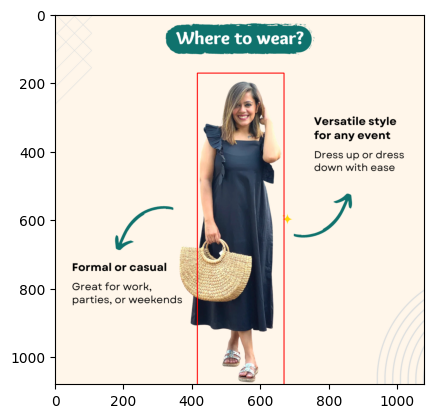

In [110]:
# Visualize the bounding box

cv2.rectangle(sample_image, (int(bounding_box[0][0]), int(bounding_box[0][1])), (int(bounding_box[0][0]+bounding_box[0][2]), int(bounding_box[0][1]+bounding_box[0][3])), (255, 0, 0), 2)
plt.imshow(sample_image)

In [111]:
# Initialize the easyocr reader
# Run the reader on the sample image
# The result is a list of tuples containing the bounding box, text and confidence score

reader = easyocr.Reader(['en']) # this needs to run only once to load the model into memory
result = reader.readtext(sample_image)
result

[([[352, 44], [730, 44], [730, 98], [352, 98]],
  'Where to wear?',
  0.9725445296382123),
 ([[755, 295], [1001, 295], [1001, 337], [755, 337]],
  'Versatile style',
  0.7280772017478758),
 ([[753, 337], [985, 337], [985, 377], [753, 377]],
  'for any event',
  0.9989507759279234),
 ([[755, 395], [1025, 395], [1025, 431], [755, 431]],
  'Dress up or dress',
  0.9387831480764784),
 ([[754, 432], [996, 432], [996, 464], [754, 464]],
  'down with ease',
  0.9708797933029888),
 ([[48, 724], [332, 724], [332, 756], [48, 756]],
  'Formal or casual',
  0.9559546727881729),
 ([[48, 780], [284, 780], [284, 812], [48, 812]],
  'Great for work,',
  0.8200966737145359),
 ([[46, 814], [377, 814], [377, 857], [46, 857]],
  'parties, or weekends',
  0.7679766467740027)]

In [112]:
# Retrieve just the bounding boxes from the result
# The format of the bounding box is different from that output by the yoloV3 model
# This format gives all the four coordinates of the bounding box

bounding_boxes = []
for detections in result:
    bounding_boxes.append(detections[0])
bounding_boxes

[[[352, 44], [730, 44], [730, 98], [352, 98]],
 [[755, 295], [1001, 295], [1001, 337], [755, 337]],
 [[753, 337], [985, 337], [985, 377], [753, 377]],
 [[755, 395], [1025, 395], [1025, 431], [755, 431]],
 [[754, 432], [996, 432], [996, 464], [754, 464]],
 [[48, 724], [332, 724], [332, 756], [48, 756]],
 [[48, 780], [284, 780], [284, 812], [48, 812]],
 [[46, 814], [377, 814], [377, 857], [46, 857]]]

In [113]:
# Function to convert the bounding box format from easyocr to yoloV3 format
# i.e. convert the bounding box from four coordinates to two coordinates and width and height

def convert_ocr_bounding_box(bounding_box):
    (x1, y1), (x2, y2), (x3, y3), (x4, y4) = bounding_box
    return np.array([x1, y1, x2-x1, y3-y1])

In [114]:
# Check if the function works on one of the bounding boxes

convert_ocr_bounding_box(bounding_boxes[0])

array([352,  44, 378,  54])

In [115]:
# Function to get the text bounding boxes from the image in yoloV3 format

def get_text_bounding_boxes(image_path):
    image = cv2.imread(image_path)
    reader = easyocr.Reader(['en'])
    result = reader.readtext(image)
    bounding_boxes = []
    for detections in result:
        bounding_boxes.append(convert_ocr_bounding_box(detections[0]))
    return bounding_boxes

In [116]:
# Check if the function works on the sample image

get_text_bounding_boxes(image_paths[0])

[array([352,  44, 378,  54]),
 array([755, 295, 246,  42]),
 array([753, 337, 232,  40]),
 array([755, 395, 270,  38]),
 array([753, 431, 244,  36]),
 array([ 48, 724, 284,  32]),
 array([ 48, 780, 234,  32]),
 array([ 46, 815, 331,  42])]

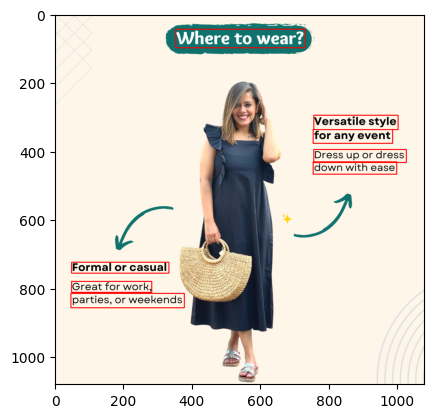

In [117]:
# Plot the bounding boxes on the image

image = cv2.imread(image_paths[0])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
for bounding_box in get_text_bounding_boxes(image_paths[0]):
    cv2.rectangle(image, (int(bounding_box[0]), int(bounding_box[1])), (int(bounding_box[0]+bounding_box[2]), int(bounding_box[1]+bounding_box[3])), (255, 0, 0), 2)
plt.imshow(image)

In [118]:
# Function to check if two bounding boxes overlap

def check_overlap(box1,box2):
    x1,y1,w1,h1 = box1
    x2,y2,w2,h2 = box2
    if x1 > x2+w2 or x2 > x1+w1:
        return False
    if y1 > y2+h2 or y2 > y1+h1:
        return False
    return True

In [119]:
# Function to check if any of the text bounding boxes overlap with any of the person bounding boxes
# Allows for multiple boxes to be passed as input

def check_overlap_boxes(person_boxes,text_boxes):
    for person_box in person_boxes:
        for text_box in text_boxes:
            if check_overlap(person_box,text_box):
                return True
    return False

In [120]:
# Finally define the function to predict if there is an overlap between the person and text bounding boxes

def predict_overlap(image_path, multiplier=1.0):
    person_bounding_boxes = get_person_bounding_boxes(image_path,multiplier)
    text_bounding_boxes = get_text_bounding_boxes(image_path)
    return check_overlap_boxes(person_bounding_boxes,text_bounding_boxes)
    

In [121]:
# Check if the function works on the sample image

predict_overlap(image_paths[0])

False

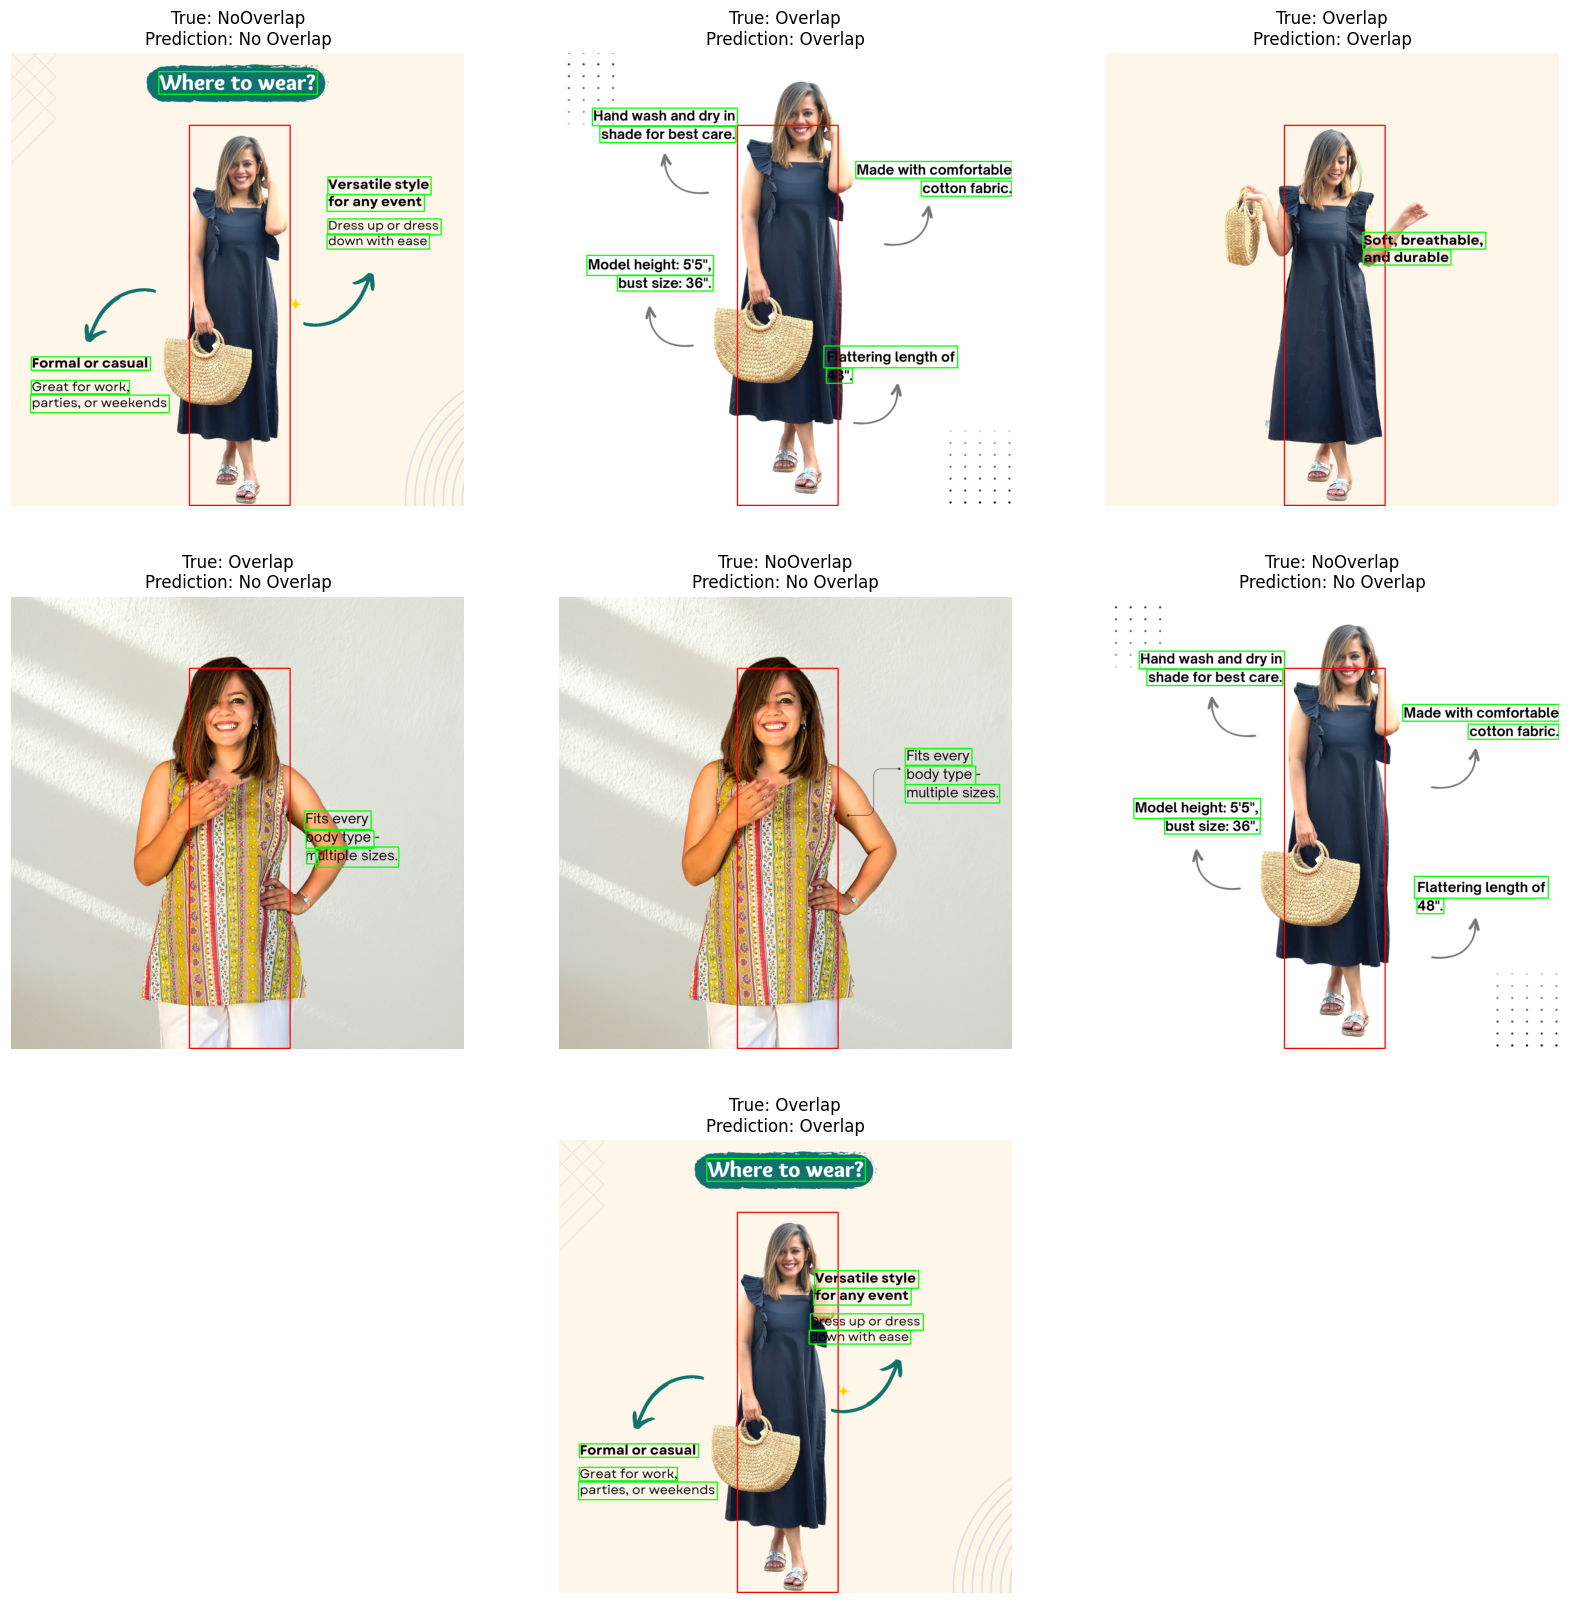

In [122]:
# Now that we have a working prediction function
# Predict for all the test images and visualize the results

length = len(image_paths)
image_names = os.listdir('./assignment/AI Applied Researcher Task')
fig, ax = plt.subplots(3,3, figsize=(20, 20))
for i in range(3):
    for j in range(3):
        ax[i][j].axis('off')
        if i*3+j >= length: continue
        prediction = "Overlap" if predict_overlap(image_paths[i*3+j],multiplier=1.0) else "No Overlap"
        true_val = image_names[i*3+j][2:-4]
        person_bounding_boxes = get_person_bounding_boxes(image_paths[i*3+j])
        text_bounding_boxes = get_text_bounding_boxes(image_paths[i*3+j])
        image = cv2.imread(image_paths[i*3+j])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        for person_box in person_bounding_boxes:
            cv2.rectangle(image, (int(person_box[0]), int(person_box[1])), (int(person_box[0]+person_box[2]), int(person_box[1]+person_box[3])), (255, 0, 0), 2)
        for text_box in text_bounding_boxes:
            cv2.rectangle(image, (int(text_box[0]), int(text_box[1])), (int(text_box[0]+text_box[2]), int(text_box[1]+text_box[3])), (0, 255, 0), 2)
        if i*3+j == length-1: j = 1
        ax[i][j].set_title(f"True: {true_val}\nPrediction: {prediction}")
        ax[i][j].imshow(image)

# As we can see we do quite well on the test images
# However, we can see that the model fails on one of the images which is because the bounding box for the person is very slim and does not include the entire person
# This can be fixed by increasing the multiplier in the get_person_bounding_boxes function

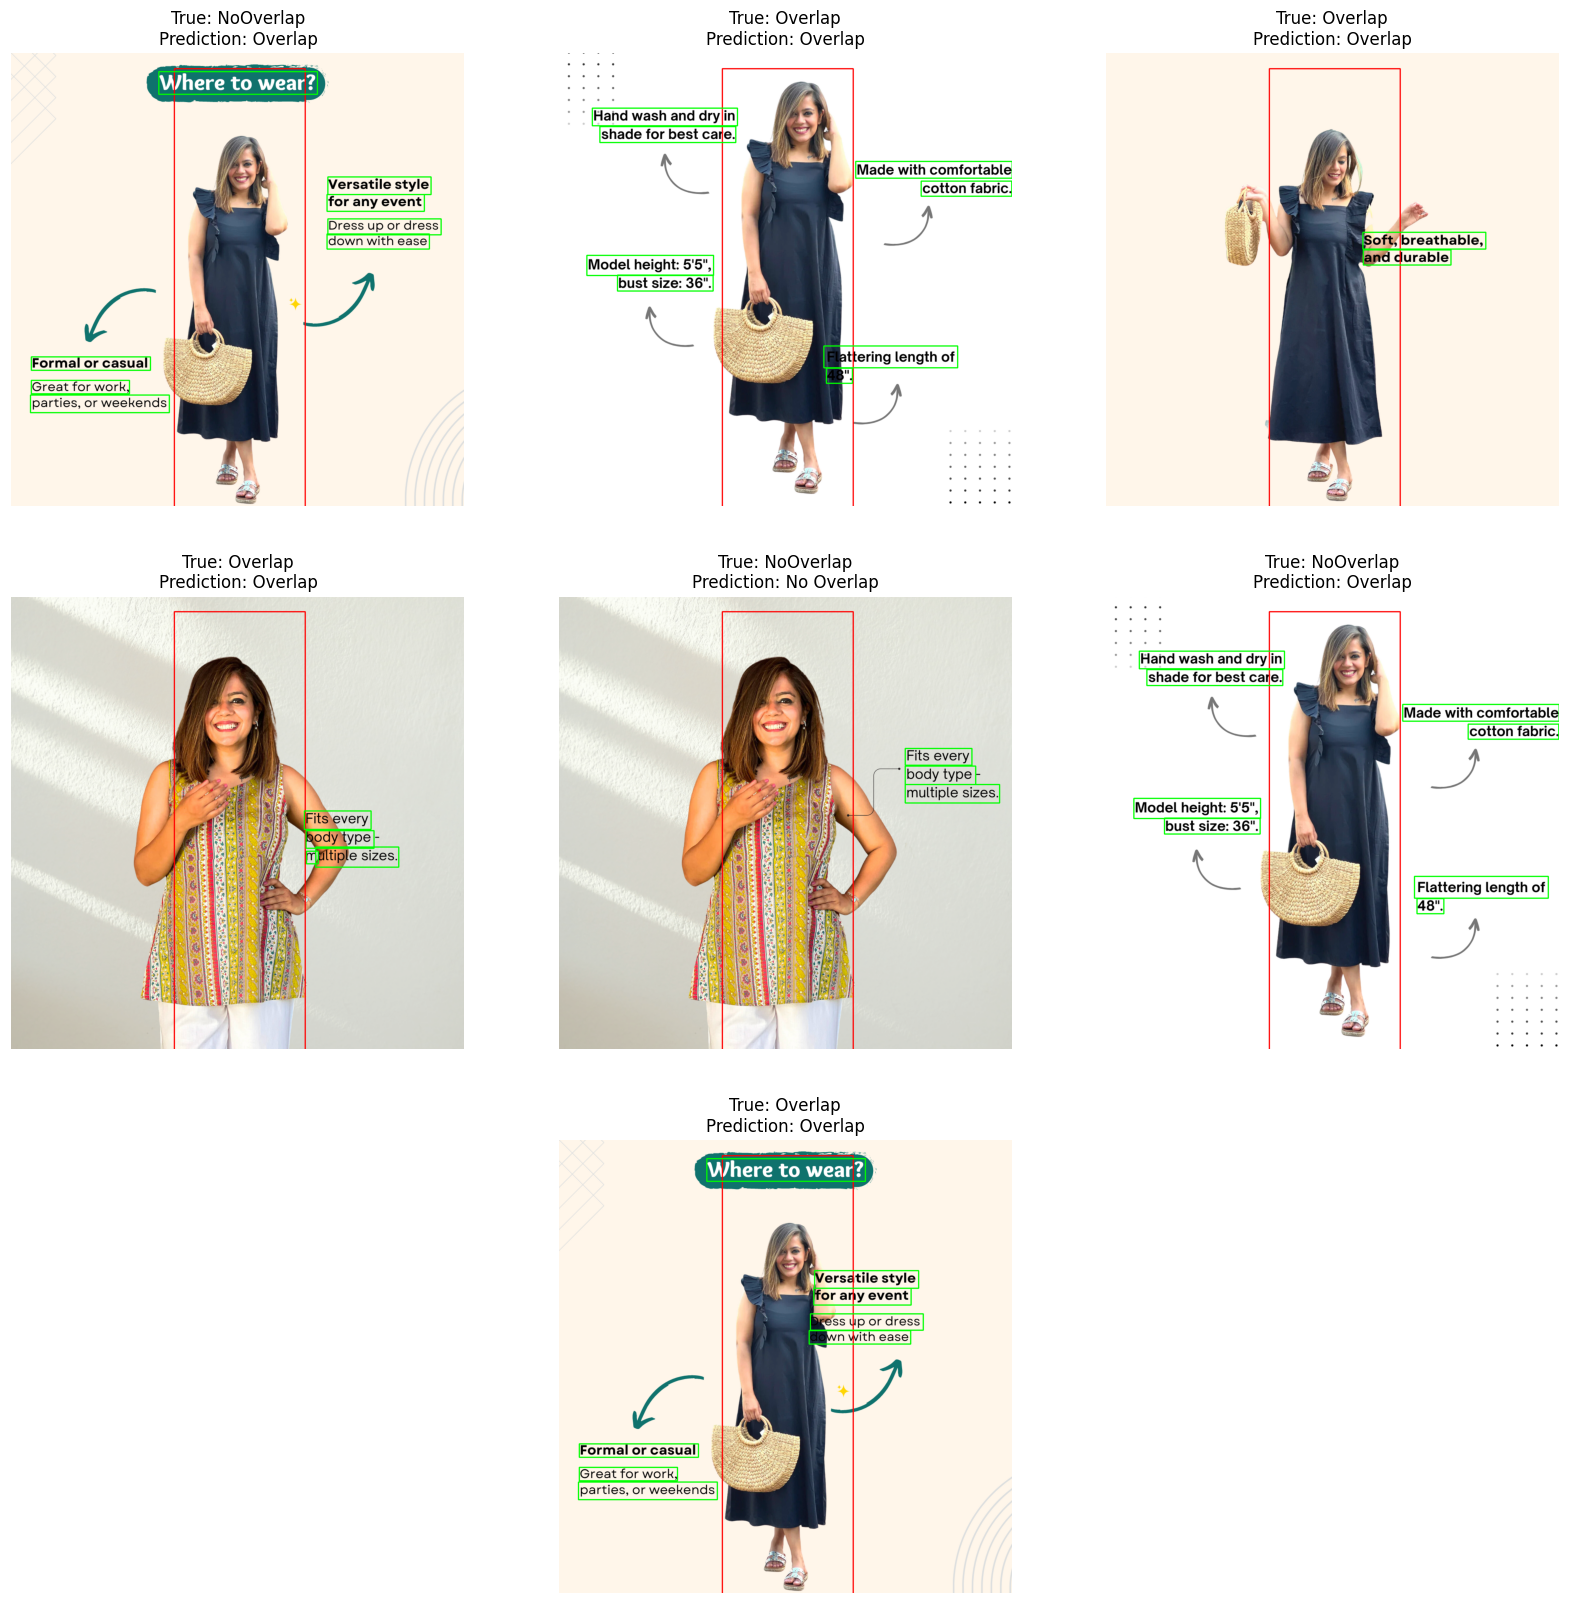

In [123]:
# Run the function with a multiplier of 1.3

length = len(image_paths)
image_names = os.listdir('./assignment/AI Applied Researcher Task')
fig, ax = plt.subplots(3,3, figsize=(20, 20))
for i in range(3):
    for j in range(3):
        ax[i][j].axis('off')
        if i*3+j >= length: continue
        prediction = "Overlap" if predict_overlap(image_paths[i*3+j],1.3) else "No Overlap"
        true_val = image_names[i*3+j][2:-4]
        
        person_bounding_boxes = get_person_bounding_boxes(image_paths[i*3+j],1.3)
        text_bounding_boxes = get_text_bounding_boxes(image_paths[i*3+j])
        image = cv2.imread(image_paths[i*3+j])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        for person_box in person_bounding_boxes:
            cv2.rectangle(image, (int(person_box[0]), int(person_box[1])), (int(person_box[0]+person_box[2]), int(person_box[1]+person_box[3])), (255, 0, 0), 2)
        for text_box in text_bounding_boxes:
            cv2.rectangle(image, (int(text_box[0]), int(text_box[1])), (int(text_box[0]+text_box[2]), int(text_box[1]+text_box[3])), (0, 255, 0), 2)
        if i*3+j == length-1: j = 1
        ax[i][j].set_title(f"True: {true_val}\nPrediction: {prediction}")
        ax[i][j].imshow(image)

# As we can see the model now correctly predicts the overlap for the image where it previously failed
# However, it now fails on another image
# So now we move to a different approach

# APPROACH 2: Using semantic segmentation for extracting pixel-wise masks

In [124]:
# We will use the DeepLabV3 model to get the segmentation mask for the person and text
# The model is downloaded from the pytorch hub
# References: https://pytorch.org/hub/pytorch_vision_deeplabv3_resnet101/
#             https://towardsdatascience.com/semantic-image-segmentation-with-deeplabv3-pytorch-989319a9a4fb

def load_model():
    # Load the DeepLab v3 model to system
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = torch.hub.load('pytorch/vision:v0.6.0', 'deeplabv3_resnet101', pretrained=True)
    model.to(device).eval()
    return model

In [125]:
# Load the model

segmentation_model = load_model()

Using cache found in /home/shubham/.cache/torch/hub/pytorch_vision_v0.6.0
/home/shubham/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/shubham/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [126]:
# Function to get the segmenation output for the image
# The following code is taken from the given reference
# The function returns the segmentation mask for all the classes that the model can detect
# However are only interested in the person so we define a function to get the person mask later 

def get_pred(img, model):
  # See if GPU is available and if yes, use it
  device = "cuda" if torch.cuda.is_available() else "cpu"

  # Define the standard transforms that need to be done at inference time
  imagenet_stats = [[0.485, 0.456, 0.406], [0.485, 0.456, 0.406]]
  preprocess = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                               torchvision.transforms.Normalize(mean = imagenet_stats[0],
                                                                                std  = imagenet_stats[1])])
  input_tensor = preprocess(img).unsqueeze(0)
  input_tensor = input_tensor.to(device)

  # Make the predictions for labels across the image
  with torch.no_grad():
      output = model(input_tensor)["out"][0]
      output = output.argmax(0)

  # Return the predictions
  return output.cpu().numpy()

[ 0 15]


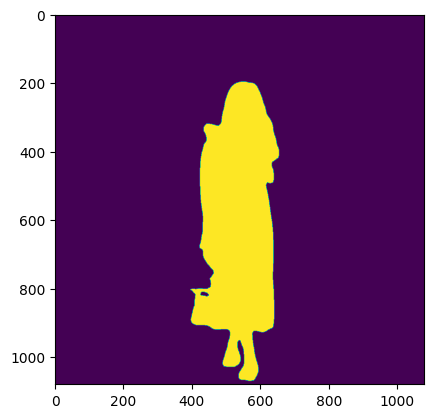

In [127]:
# Check if the function works on the sample image
# I have also printed the unique labels in the segmentation mask to show that the model can detect multiple classes
# 0 is the background class and 15 is the person class

img = cv2.imread(image_paths[0])
pred = get_pred(img, segmentation_model)
print(np.unique(pred))
plt.imshow(pred)

In [128]:
# Function to get the person mask from the segmentation mask
# Only the pixels with value 15 correspond to the person class
# So we set all the other pixels to 0 and the pixels with value 15 to 255

def get_person_mask(img, model):
    # See if GPU is available and if yes, use it
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Define the standard transforms that need to be done at inference time
    imagenet_stats = [[0.485, 0.456, 0.406], [0.485, 0.456, 0.406]]
    preprocess = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                torchvision.transforms.Normalize(mean = imagenet_stats[0],
                                                                                    std  = imagenet_stats[1])])
    input_tensor = preprocess(img).unsqueeze(0)
    input_tensor = input_tensor.to(device)

    # Make the predictions for labels across the image
    with torch.no_grad():
        output = model(input_tensor)["out"][0]
        output = output.argmax(0)

    mask = np.zeros_like(img)
    output = output.cpu().numpy()
    mask[output == 15] = 255
    return mask


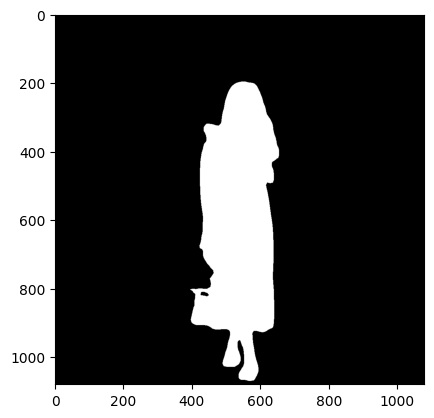

In [129]:
# Check if the function works on the sample image

mask = get_person_mask(img, segmentation_model)
plt.imshow(mask)

In [130]:
# Function to predict if there is an overlap between the person and text bounding boxes
# The function uses the person mask to check if any of the text bounding boxes overlap with the person mask
# i.e. If any of the text bounding boxes have a pixel with value 255 in the person mask

def predict_overlap(image_path):
    img = cv2.imread(image_path)
    person_mask = get_person_mask(img, segmentation_model)
    text_bounding_boxes = get_text_bounding_boxes(image_path)
    for text_box in text_bounding_boxes:
        if person_mask[int(text_box[1]):int(text_box[1]+text_box[3]),int(text_box[0]):int(text_box[0]+text_box[2])].any():
            return True
    return False

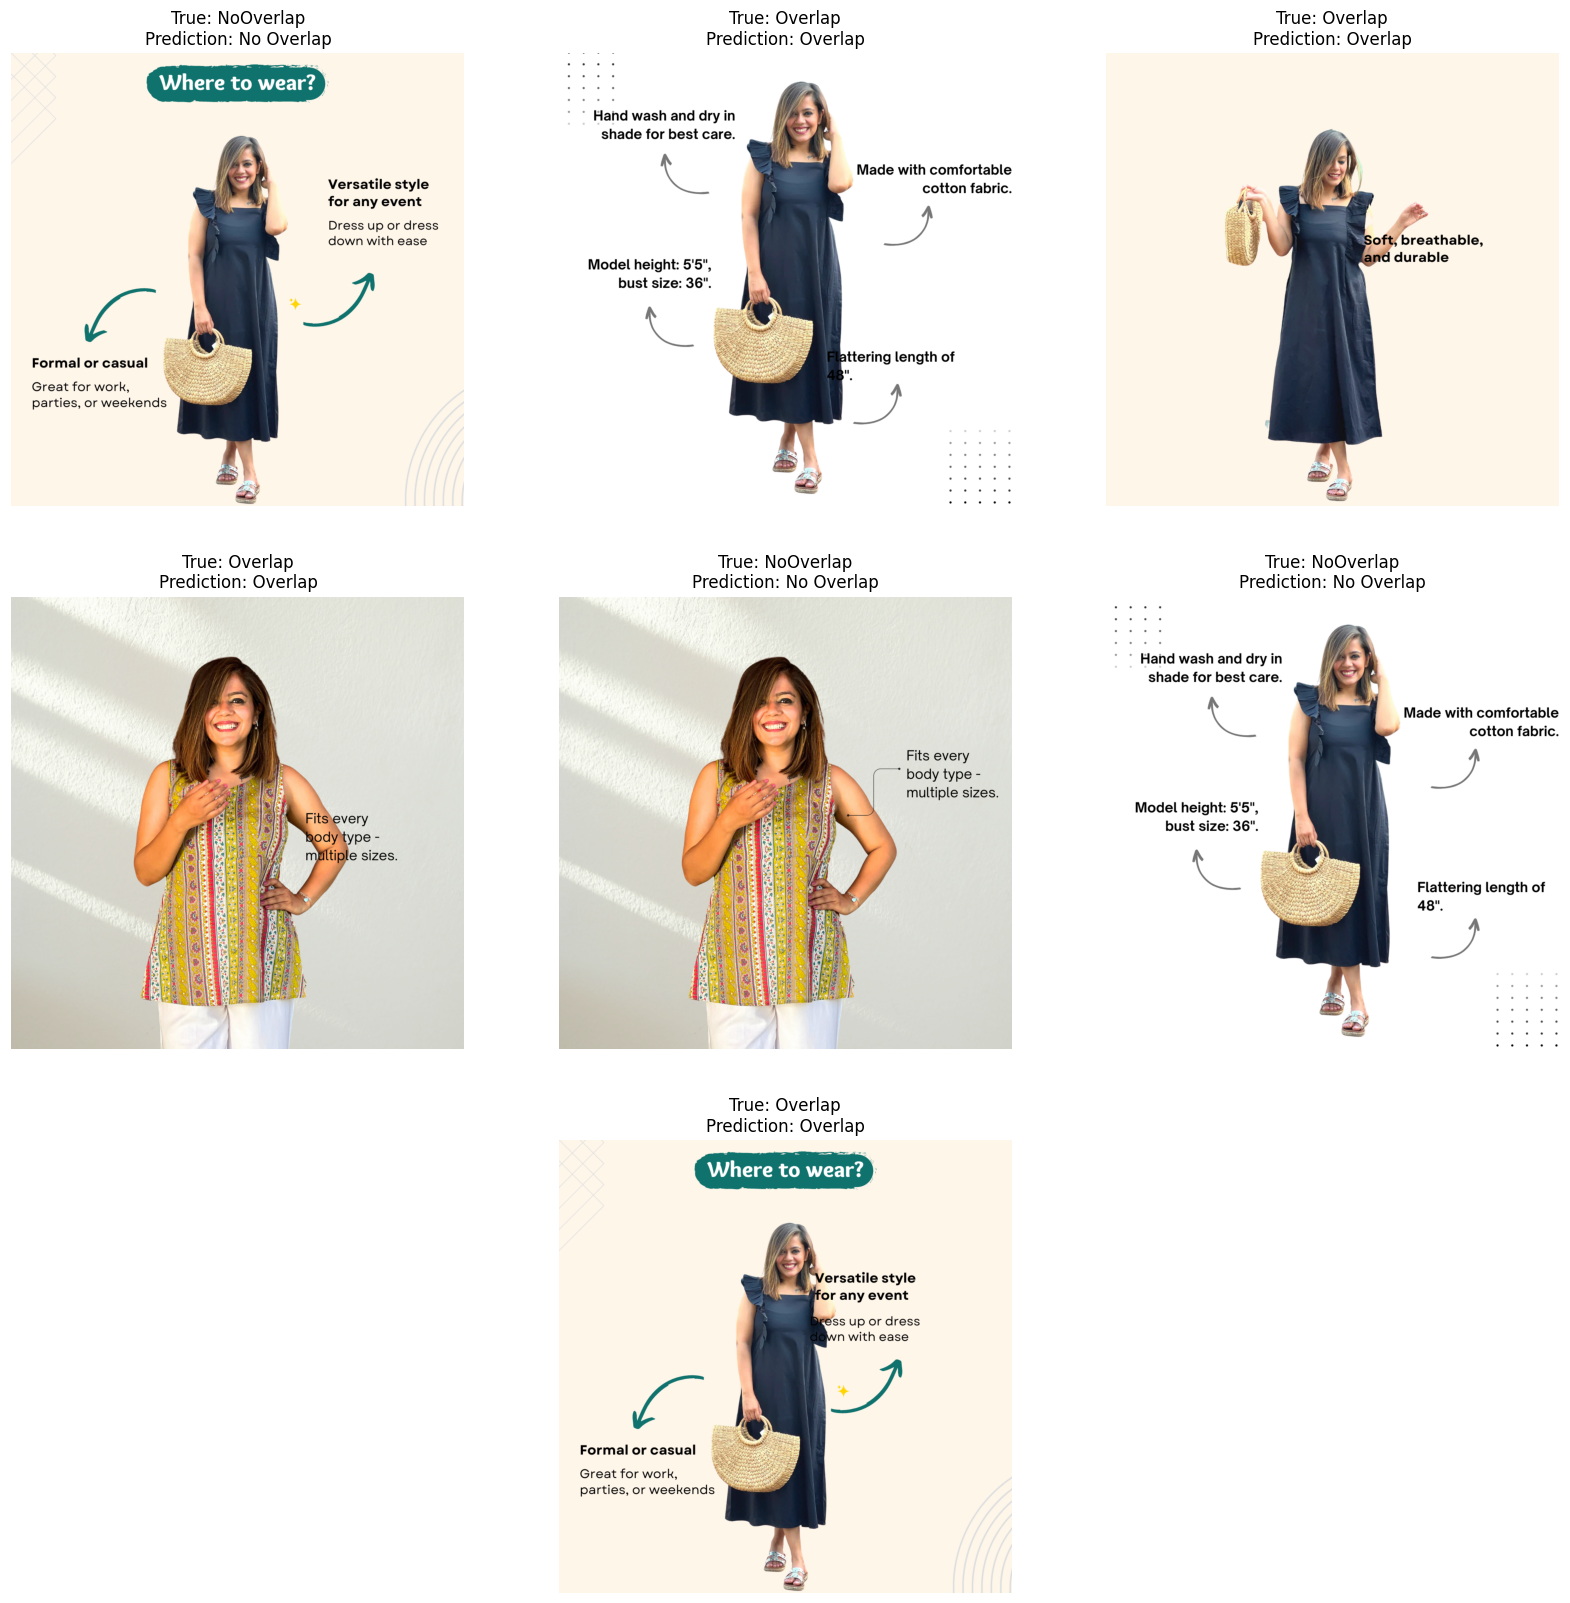

In [131]:
# Run the prediction function on the test images and visualize the results
# And voila! We get 100% accuracy on the test images

length = len(image_paths)
image_names = os.listdir('./assignment/AI Applied Researcher Task')
fig, ax = plt.subplots(3, 3, figsize=(20, 20))
for i in range(3):
    for j in range(3):
        ax[i][j].axis('off')
        if i*3+j >= length: 
            ax[i][j].axis('off') 
            continue
        image = cv2.imread(image_paths[i*3+j])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        prediction = "Overlap" if predict_overlap(image_paths[i*3+j]) else "No Overlap"
        true_val = image_names[i*3+j][2:-4]
        if i*3+j == length-1: j = 1
        ax[i][j].set_title(f"True: {true_val}\nPrediction: {prediction}")
        ax[i][j].imshow(image)

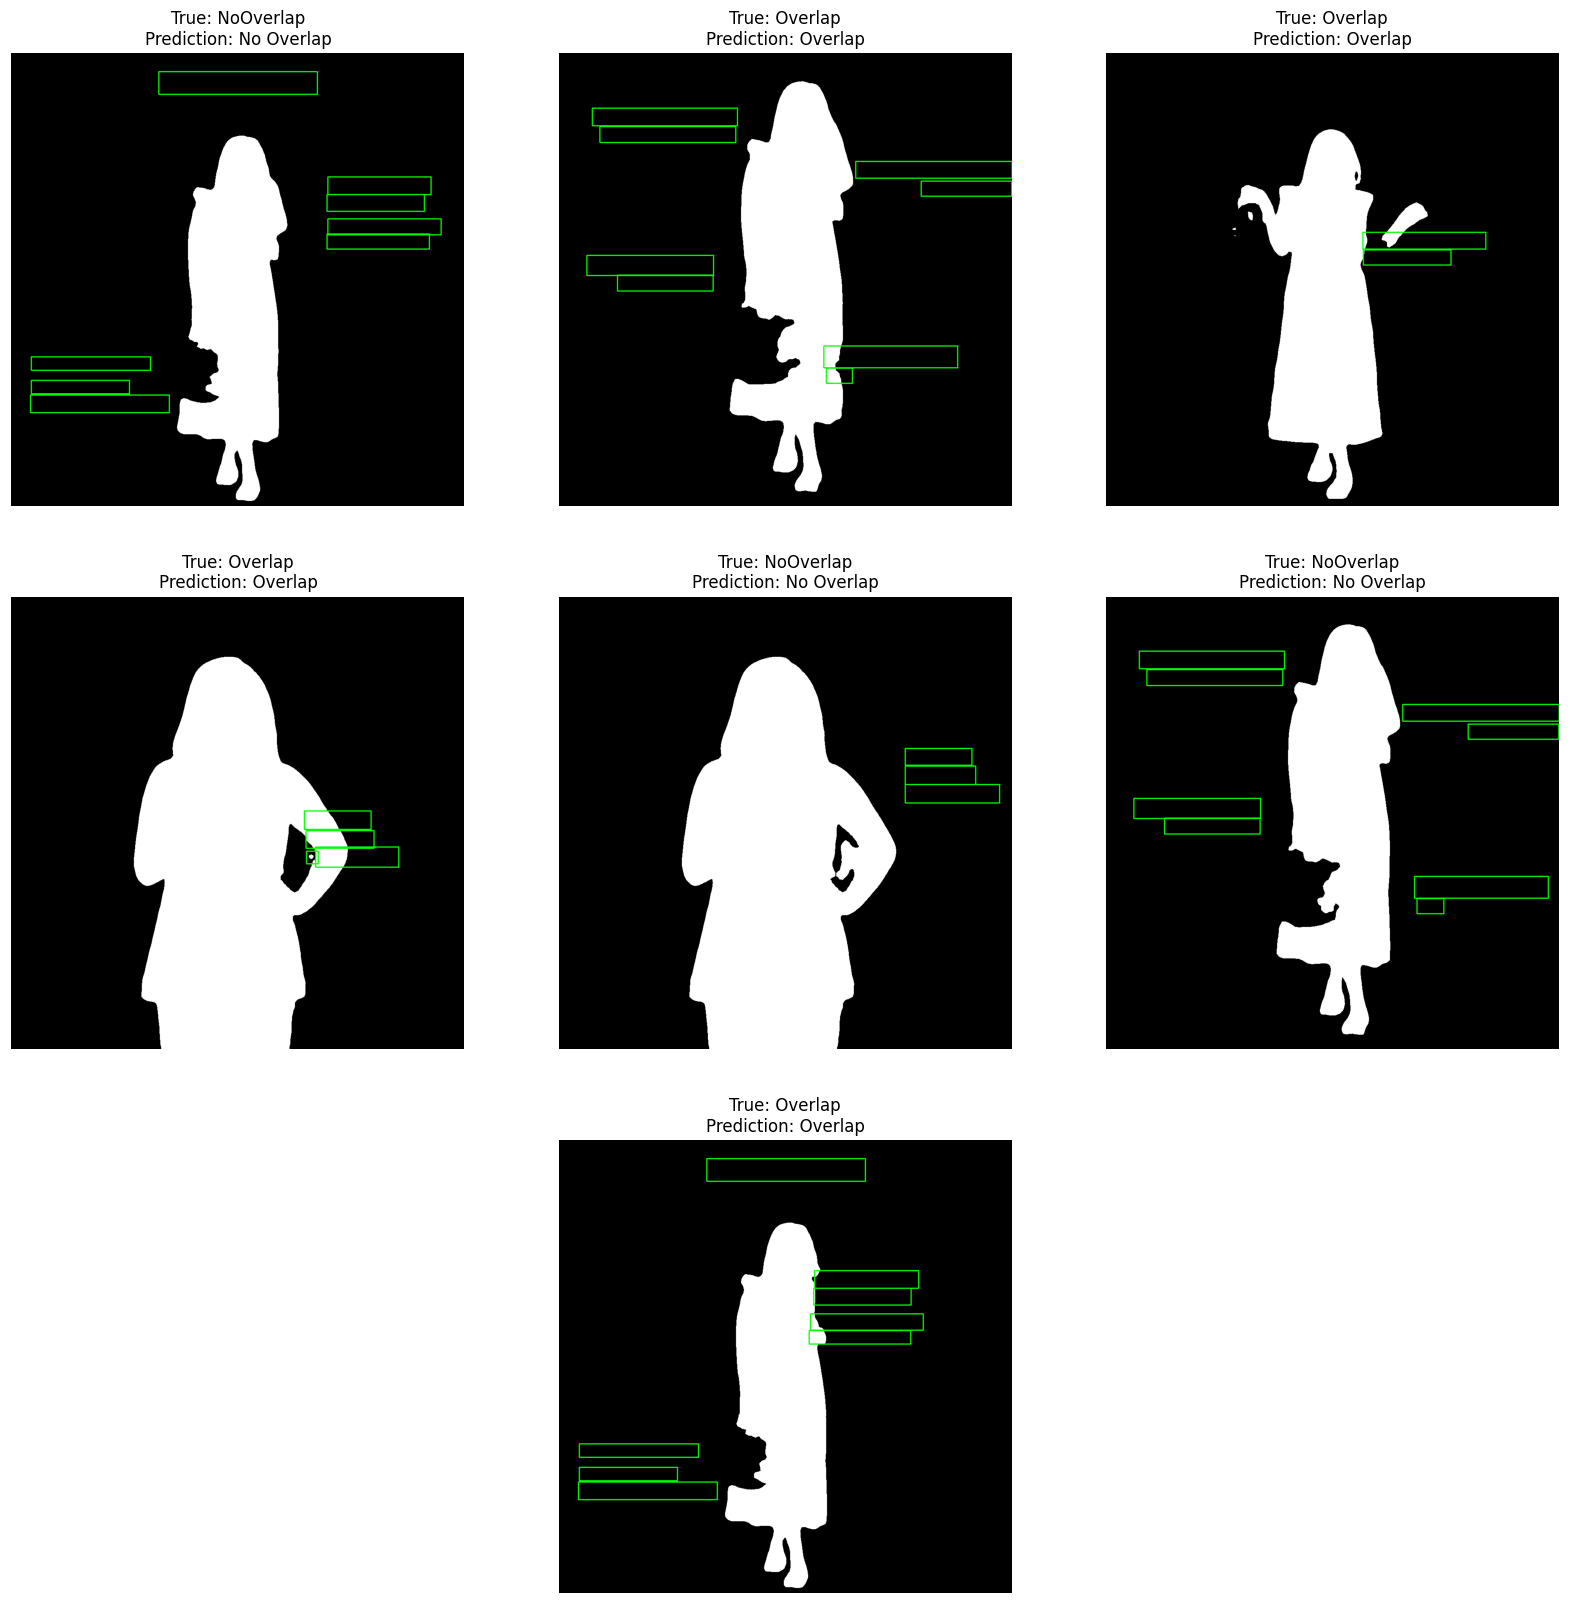

In [132]:
# Visualize the masks and bounding boxes for the test images

length = len(image_paths)
image_names = os.listdir('./assignment/AI Applied Researcher Task')
fig, ax = plt.subplots(3, 3, figsize=(20, 20))
for i in range(3):
    for j in range(3):
        ax[i][j].axis('off')
        if i*3+j >= length: 
            ax[i][j].axis('off') 
            continue
        image = cv2.imread(image_paths[i*3+j])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        prediction = "Overlap" if predict_overlap(image_paths[i*3+j]) else "No Overlap"
        true_val = image_names[i*3+j][2:-4]
        person_mask = get_person_mask(image, segmentation_model)
        text_bounding_boxes = get_text_bounding_boxes(image_paths[i*3+j])
        for text_box in text_bounding_boxes:
            cv2.rectangle(person_mask, (int(text_box[0]), int(text_box[1])), (int(text_box[0]+text_box[2]), int(text_box[1]+text_box[3])), (0, 255, 0), 2)
        if i*3+j == length-1: j = 1
        ax[i][j].set_title(f"True: {true_val}\nPrediction: {prediction}")
        ax[i][j].imshow(person_mask)